# Complete The Look (CTL)

Data Exploration [https://github.com/kang205/STL-Dataset]

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import heapq
import json
import numpy
import os
import pickle
import random
from tqdm import tqdm
import tensorflow as tf

from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
data_dir = "/recsys_data/RecSys/fashion/STL-Dataset"

fashion_data = []
with open(os.path.join(data_dir, "fashion.json"), 'r') as fr:
    for line in fr:
        fashion_data.append(json.loads(line.strip()))
print(len(fashion_data))

72198


In [4]:
fashion_data[0]

{'product': '0027e30879ce3d87f82f699f148bff7e',
 'scene': 'cdab9160072dd1800038227960ff6467',
 'bbox': [0.434097, 0.859363, 0.560254, 1.0]}

In [8]:
def view_data(example):
    product_url = convert_to_url(example['product'])
    scene_url = convert_to_url(example['scene'])
    bb = example["bbox"]
    
    response = requests.get(product_url)
    img_product = Image.open(BytesIO(response.content))
    
    response = requests.get(scene_url)
    img_scene = Image.open(BytesIO(response.content))
    
    h, w = img_scene.height, img_scene.width
#     bbox = [(int(bb[0]*h), int(bb[1]*w)), (int(bb[2]*h), int(bb[3]*w))]
    bbox = [(int(bb[0]*w), int(bb[1]*h)), (int(bb[2]*w), int(bb[3]*h))]
    print(h, w, bbox)

    figure, axis = plt.subplots(1, 2, figsize=(10,5))
    img1 = ImageDraw.Draw(img_scene)  
    img1.rectangle(bbox, outline ="red")
    imgplot = axis[0].imshow(img_scene)
#     img_scene.show()

#     draw = ImageDraw.Draw(img_scene)
#     draw.rectangle(bbox, outline='yellow', width=5)
#     axis[0].axis('off')

    imgplot = axis[1].imshow(img_product)
    axis[1].axis('off')
    plt.show()
    
    return img_product, img_scene
    
def convert_to_url(signature):
    prefix = 'http://i.pinimg.com/400x/%s/%s/%s/%s.jpg'
    return prefix % (signature[0:2], signature[2:4], signature[4:6], signature)

(400, 503)
503 400 [(173, 432), (224, 503)]


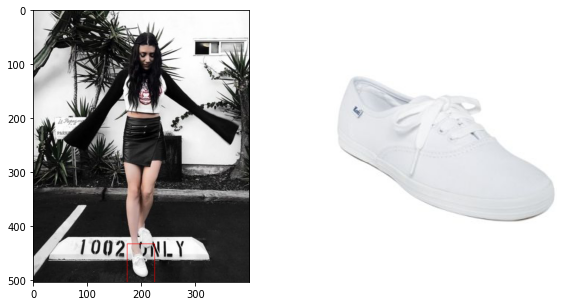

In [7]:
img_p, img_s = view_data(fashion_data[0])

(400, 458)
458 400 [(87, 93), (272, 200)]


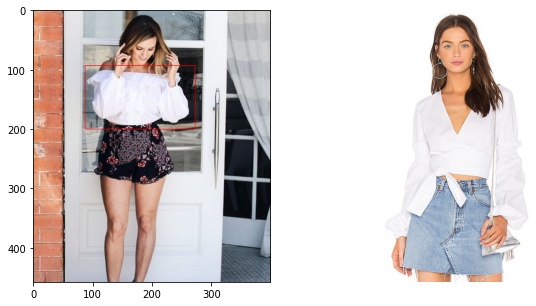

In [14]:
img_p, img_s = view_data(fashion_data[1000])

In [11]:
fashion_data[0]

{'product': '0027e30879ce3d87f82f699f148bff7e',
 'scene': 'cdab9160072dd1800038227960ff6467',
 'bbox': [0.434097, 0.859363, 0.560254, 1.0]}

## Type-aware Embedding

Data preparation - typespace

In [48]:
rootdir = "/recsys_data/RecSys/Zalando_Outfit/female/Outfit_Data"
train_file = "zalando_female_outfit_data_18k_and_new_modified_format_train_actual.json"
data_json = os.path.join(rootdir, "Train", train_file)

outfit_data = json.load(open(data_json, 'r'))
low_cats, mid_cats, high_cats = set(), set(), set()
styles = []
for outfit in outfit_data:
    outfit_style = outfit["outfit_occasion"]
    lcats = outfit['low_level_cats']
    mcats = outfit['mid_level_cats']
    hcats = outfit['high_level_cats']
    styles.append(outfit_style)
    low_cats |= set(lcats)
    mid_cats |= set(mcats)
    high_cats |= set(hcats)
len(set(styles)), len(low_cats), len(mid_cats), len(high_cats)

(7, 229, 52, 9)

In [49]:
Counter(styles).most_common()

[('casual', 13062),
 ('travel', 2128),
 ('party', 1215),
 ('athleisure', 1160),
 ('work', 841),
 ('sporty', 534),
 ('relax', 473)]

In [20]:
high_cats

{'accessory',
 'all-body',
 'beachwear_swimwear',
 'bodywear_nightwear_innerwear',
 'bottomwear',
 'footwear',
 'jewellery',
 'outerwear',
 'topwear'}

In [26]:
# polyvore: {'shoes', 'outerwear', 'sunglasses', 'scarves', 'all-body', 'hats', 'accessories', 'tops', 'bottoms', 'jewellery', 'bags'}
# n = 11, total combinations (including self-self) = n(n+1)/2 = 66

from itertools import combinations, combinations_with_replacement

out_dir = "/recsys_data/RecSys/Zalando_Outfit/female/Outfit_Data"
out_file = "typespaces.p"
count = 0
out_res = []
for c in combinations_with_replacement(high_cats, r=2):
    out_res.append(c)
    count += 1
count

45

In [29]:
bigger_res = []
for s in styles:
    new_res = [(s, c[0], c[1]) for c in out_res]
    bigger_res += new_res
len(bigger_res)

315

In [64]:
# search which combinations are not present
pos_pairs = set()
for outfit in outfit_data:
    outfit_style = outfit["outfit_occasion"]
    items = outfit['item_ids']
    cnt = len(items)
    categories = outfit['high_level_cats']
    for j in range(cnt-1):
        for k in range(j+1, cnt):
            tup = (outfit_style, categories[j], categories[k])
            tup_ = (outfit_style, categories[k], categories[j])
            if tup in bigger_res or tup_ in bigger_res:
                pos_pairs.add(tup)
            
            if tup not in bigger_res and tup_ not in bigger_res:
                print(tup)
len(pos_pairs)

349

In [60]:
len(set(bigger_res) - set(pos_pairs)), len(set(pos_pairs) - set(bigger_res))

(115, 149)

In [63]:
for x in set(pos_pairs) - set(bigger_res):
    if (x[0], x[2], x[1]) not in bigger_res:
        print(x)

In [62]:
[x for x in bigger_res if x[0]=='athleisure']

[('athleisure', 'outerwear', 'outerwear'),
 ('athleisure', 'outerwear', 'bodywear_nightwear_innerwear'),
 ('athleisure', 'outerwear', 'footwear'),
 ('athleisure', 'outerwear', 'bottomwear'),
 ('athleisure', 'outerwear', 'all-body'),
 ('athleisure', 'outerwear', 'jewellery'),
 ('athleisure', 'outerwear', 'beachwear_swimwear'),
 ('athleisure', 'outerwear', 'topwear'),
 ('athleisure', 'outerwear', 'accessory'),
 ('athleisure',
  'bodywear_nightwear_innerwear',
  'bodywear_nightwear_innerwear'),
 ('athleisure', 'bodywear_nightwear_innerwear', 'footwear'),
 ('athleisure', 'bodywear_nightwear_innerwear', 'bottomwear'),
 ('athleisure', 'bodywear_nightwear_innerwear', 'all-body'),
 ('athleisure', 'bodywear_nightwear_innerwear', 'jewellery'),
 ('athleisure', 'bodywear_nightwear_innerwear', 'beachwear_swimwear'),
 ('athleisure', 'bodywear_nightwear_innerwear', 'topwear'),
 ('athleisure', 'bodywear_nightwear_innerwear', 'accessory'),
 ('athleisure', 'footwear', 'footwear'),
 ('athleisure', 'footw

In [28]:
import pickle

with open(os.path.join(out_dir, out_file), 'wb') as fw:
    pickle.dump(out_res, fw)

In [31]:
with open(os.path.join(out_dir, "typespaces_with_style.p"), 'wb') as fw:
    pickle.dump(bigger_res, fw)

In [32]:
outfit

{'gender': 'female',
 'outfit_id': 'AN651H0L7-B11@4',
 'outfit_img_url': 'https://mosaic04.ztat.net/vgs/media/outfit-image-mhq/AN/65/1H/0L/7B/11/AN651H0L7-B11@4.jpg?imwidth=1000',
 'outfit_url': 'https://www.zalando.co.uk/outfits/dWRkZCMIRwS/',
 'item_ids': ['SE521E0IJ-A11@12.jpg',
  'WL521A044-Q11@2.jpg',
  'P6311A01Z-Q11@12.jpg',
  'AN651H0L7-B11@2.jpg',
  'MAY51L03A-F11@12.jpg',
  'PI851L0FA-F11@6.jpg'],
 'low_level_cats': ['blouse',
  'trouser',
  'heeled-mules',
  'handbag',
  'ring',
  'earrings'],
 'mid_level_cats': ['top',
  'trouser',
  'heels',
  'bag',
  'jewellery',
  'jewellery'],
 'high_level_cats': ['topwear',
  'bottomwear',
  'footwear',
  'accessory',
  'jewellery',
  'jewellery'],
 'outfit_occasion': 'casual'}

In [43]:
import pandas as pd
from collections import Counter 

cmp_file = "/recsys_data/RecSys/Zalando_Outfit/female/Compat_AUC_Data/Test/Soft Negative/test_compat_questions_soft_neg_replacement_all_random_seed_1.txt"
labels, cls = [], []
with open(cmp_file, "r") as fr:
    for line in fr:
        elems = line.strip().split()
        labels.append(elems[0])
        cls.append(elems[1])


In [46]:
Counter(labels), Counter(cls).most_common()

(Counter({'1': 5809, '0': 5809}),
 [('0', 7834),
  ('1', 1262),
  ('5', 724),
  ('4', 696),
  ('6', 502),
  ('2', 320),
  ('3', 280)])

## Use Embedding Model for Outfit Generation

In [1]:
import heapq
import json
import sys
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [2]:
sys.path.insert(0, "/recsys_data/RecSys/fashion/fashion-compatibility")

In [3]:
import torch
import Resnet_18
from polyvore_outfits import TripletImageLoader
from zalando_outfits import TripletImageLoaderZalando
from tripletnet import Tripletnet
from type_specific_network import TypeSpecificNet
from types import SimpleNamespace

from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

In [5]:
data_name = "zalando" # "polyvore"
text_feature_dim = 6000

if data_name == "polyvore":
    model_path = "/recsys_data/RecSys/fashion/fashion-compatibility/runs/polyvore/model_best.pth.tar"
    fn = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits/polyvore_item_metadata.json"
    meta_data = json.load(open(fn, 'r'))
else:
    model_path = "/recsys_data/RecSys/fashion/fashion-compatibility/runs/zalando/model_best.pth.tar"
    fn = "/recsys_data/RecSys/Zalando_Outfit/female/Metadata/img2high_level_cat_updated.json"
    data_file = "/recsys_data/RecSys/Zalando_Outfit/female/Outfit_Data/Train/zalando_female_outfit_data_18k_and_new_modified_format_train.json"
    meta_data = json.load(open(fn, 'r'))
    
args = SimpleNamespace(dim_embed=64, 
                       learned=False, 
                       prein=False, 
                       rand_typespaces=False, 
                       num_rand_embed=4, 
                       use_fc=True, 
                       l2_embed=True,
                       typespace_type="style",
                       margin=0.3,
                       resume=model_path,
                       learned_metric=False,
                       no_cuda=False,
                       batch_size=256,
                       datadir="/recsys_data/RecSys/fashion/polyvore-dataset",
                       polyvore_split="disjoint",
                      )

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

args.cuda = not args.no_cuda and torch.cuda.is_available()
# item meta data is part of the outfit data
kwargs = {'num_workers': 6, 'pin_memory': True} if args.cuda else {}

if data_name == "polyvore":
    test_loader_ = TripletImageLoader(args, 'test', meta_data,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.ToTensor(),
                               normalize,
                           ]))
    test_loader = torch.utils.data.DataLoader(test_loader_, batch_size=args.batch_size, shuffle=False, **kwargs)

else:
    test_loader_ = TripletImageLoaderZalando(args, 'test', meta_data,
                                             transform=transforms.Compose([
                                                  transforms.Resize(112),
                                                  transforms.CenterCrop(112),
                                                  transforms.ToTensor(),
                                                  normalize,
                                             ]), 
                                             user_file=data_file,
                                             create_task_data=False,
                                            )

    test_loader = torch.utils.data.DataLoader(test_loader_, batch_size=args.batch_size, shuffle=False, **kwargs)


In [6]:
model = Resnet_18.resnet18(pretrained=True, embedding_size=args.dim_embed)
csn_model = TypeSpecificNet(args, model, len(test_loader.dataset.typespaces))

criterion = torch.nn.MarginRankingLoss(margin=args.margin)
tnet = Tripletnet(args, csn_model, text_feature_dim, criterion)

print("=> loading checkpoint '{}'".format(args.resume))
checkpoint = torch.load(args.resume)
args.start_epoch = checkpoint['epoch']
best_acc = checkpoint['best_prec1']
tnet.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch {})"
      .format(args.resume, checkpoint['epoch']))
tnet.to('cuda')

=> loading checkpoint '/recsys_data/RecSys/fashion/fashion-compatibility/runs/zalando/model_best.pth.tar'
=> loaded checkpoint '/recsys_data/RecSys/fashion/fashion-compatibility/runs/zalando/model_best.pth.tar' (epoch 2)


Tripletnet(
  (embeddingnet): TypeSpecificNet(
    (embeddingnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [7]:
tnet.eval()
embeddings = []

# for test/val data we get images only from the data loader
for batch_idx, images in tqdm(enumerate(test_loader)):
    if args.cuda:
        images = images.cuda()
    images = Variable(images)
    embeddings.append(tnet.embeddingnet(images).data)

embeddings = torch.cat(embeddings)
metric = tnet.metric_branch

128it [00:24,  5.23it/s]


In [8]:
im2index = {}
for index, im in enumerate(test_loader_.imnames):
    im2index[im] = index


8899 MIG21N00P-K11@12.jpg bottomwear


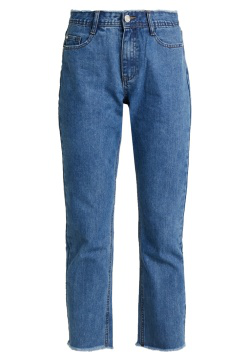

In [21]:
image_pool = test_loader_.imnames
anchor_idx = np.random.randint(len(image_pool), size=1)[0]
# anchor_idx = 4817, 8899
anchor_img = image_pool[anchor_idx]
anchor_cat = test_loader_.im2type[anchor_img]
print(anchor_idx, anchor_img, anchor_cat)

if data_name == "polyvore":
    image_dir = os.path.join(args.datadir, 'polyvore_outfits', 'images')
    anchor_path = os.path.join(image_dir, anchor_img+".jpg")
else:
    image_dir = "/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female"
    anchor_path = os.path.join(image_dir, anchor_img)

Image.open(anchor_path)

In [13]:
def plot_images(image_list, categories=None, image_dir=None):
    nrows, ncols = 1, len(image_list)
    figure, axis = plt.subplots(nrows, ncols, figsize=(20,5))
    for ii in range(ncols):
        item = image_list[ii]
        img = plt.imread(os.path.join(image_dir, item))
        imgplot = axis[ii].imshow(img)
        axis[ii].title.set_text(categories[ii])
        axis[ii].axis('off')
    plt.show()

def get_complementary_items(anchor_idx, max_num=5, style=None):
    image_dist = []
    # 'casual', 'travel', 'party', 'athleisure', 'work', 'sporty', 'relax'
    anchor_img = image_pool[anchor_idx]
    anchor_cat = test_loader_.im2type[anchor_img]
    for idx in tqdm(range(len(image_pool))):
        if idx != anchor_idx:
            test_img = image_pool[idx]
            test_cat = test_loader_.im2type[test_img]
            if test_cat == anchor_cat:
                continue
            if data_name == "polyvore":
                condition = test_loader_.get_typespace(anchor_cat, test_cat)
            else:
                condition = test_loader_.get_typespace_with_style(anchor_cat, test_cat, style)

            embed1 = embeddings[anchor_idx][condition].unsqueeze(0)
            embed2 = embeddings[idx][condition].unsqueeze(0)
            if metric is None:
                outfit_score = torch.nn.functional.pairwise_distance(
                    embed1, embed2, 2)
            else:
                outfit_score = metric(Variable(embed1 * embed2)).data
            heapq.heappush(image_dist, (outfit_score, test_img))
            
    ignore = [anchor_cat]
    count = 0
    top_images = []
    while count < max_num:
        image_ii = heapq.heappop(image_dist)[1]
        cat_ii = test_loader_.im2type[image_ii]
        if cat_ii not in ignore:
            top_images.append(image_ii)
            ignore.append(cat_ii)
            count += 1
        
    if data_name == "polyvore":
        images = [x+".jpg" for x in top_images]
    else:
        images = top_images
    categories = [test_loader_.im2type[x] for x in top_images]
    plot_images(images, categories, image_dir)
    return (images, categories)

100%|██████████| 32619/32619 [00:07<00:00, 4476.71it/s]


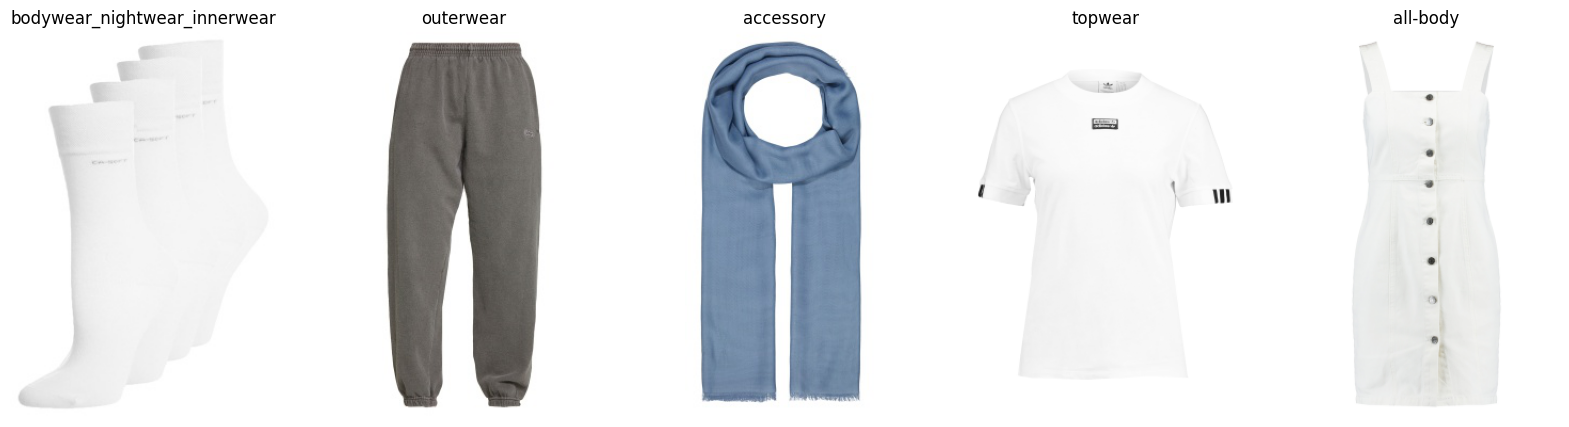

In [22]:
res = get_complementary_items(anchor_idx, style="casual")

100%|██████████| 32619/32619 [00:08<00:00, 3884.61it/s]


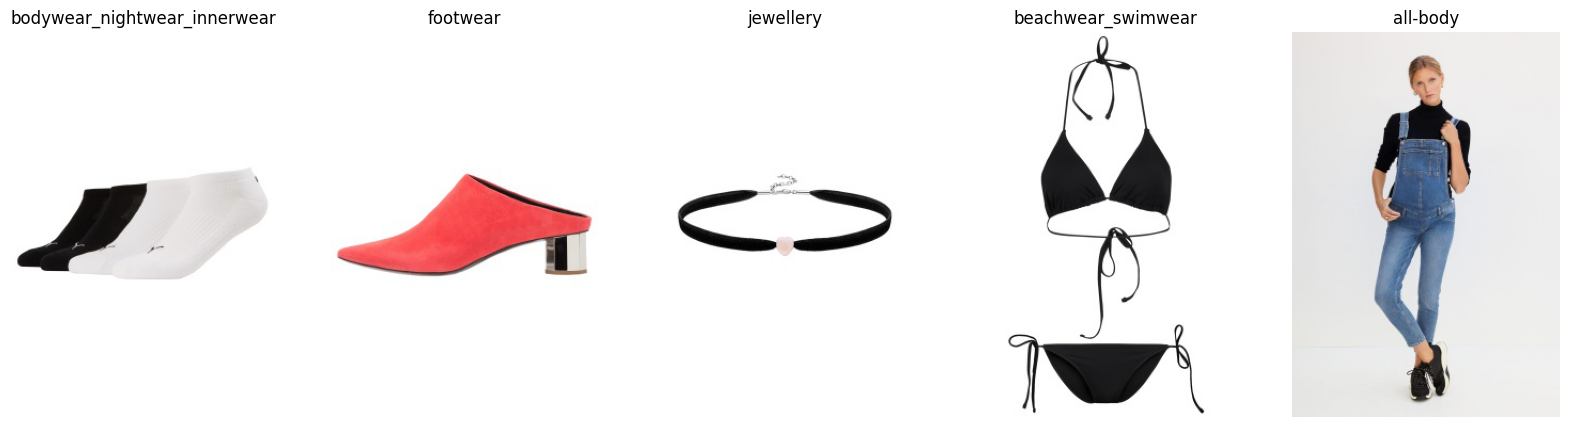

In [15]:
res = get_complementary_items(anchor_idx, style="travel")

100%|██████████| 32619/32619 [00:08<00:00, 3855.01it/s]


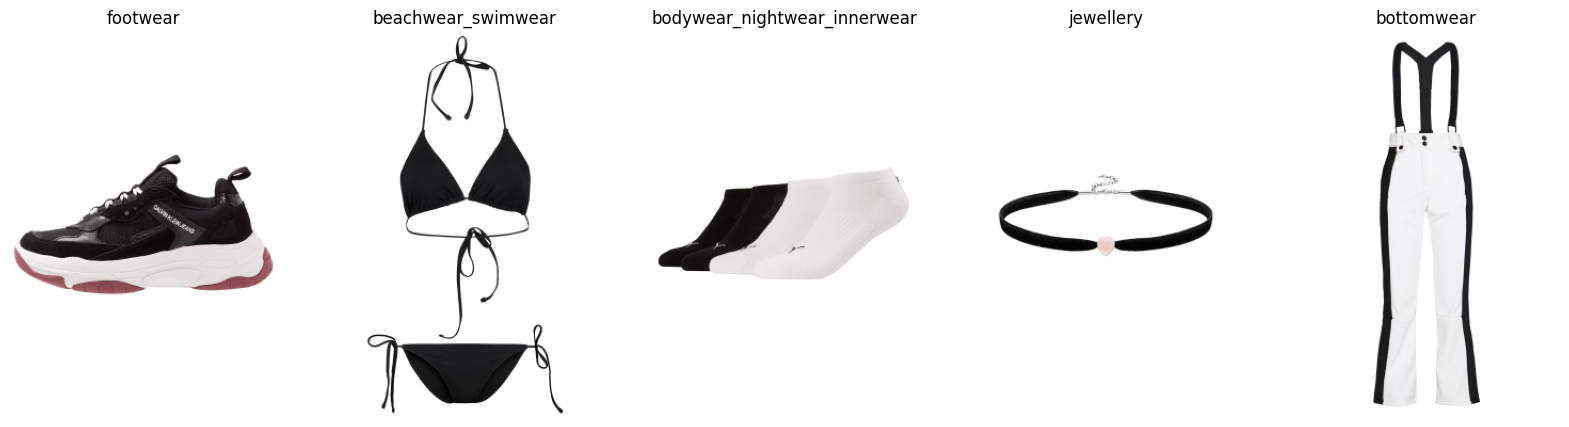

In [16]:
res = get_complementary_items(anchor_idx, style="party")

100%|██████████| 32619/32619 [00:08<00:00, 3815.56it/s]


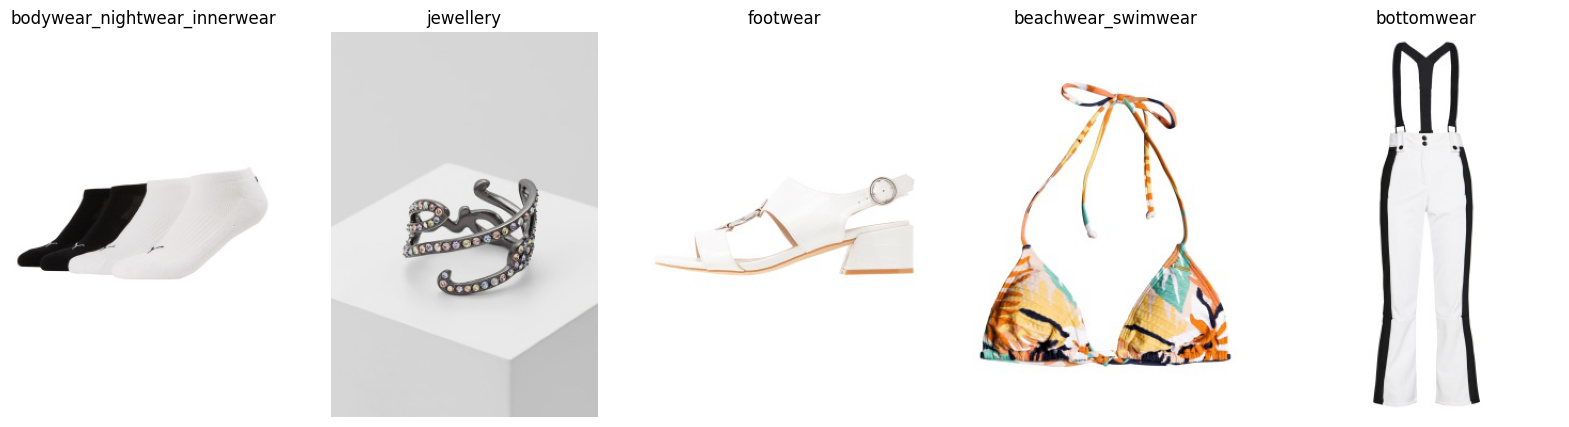

In [17]:
res = get_complementary_items(anchor_idx, style="athleisure")

100%|██████████| 32619/32619 [00:08<00:00, 3969.26it/s]


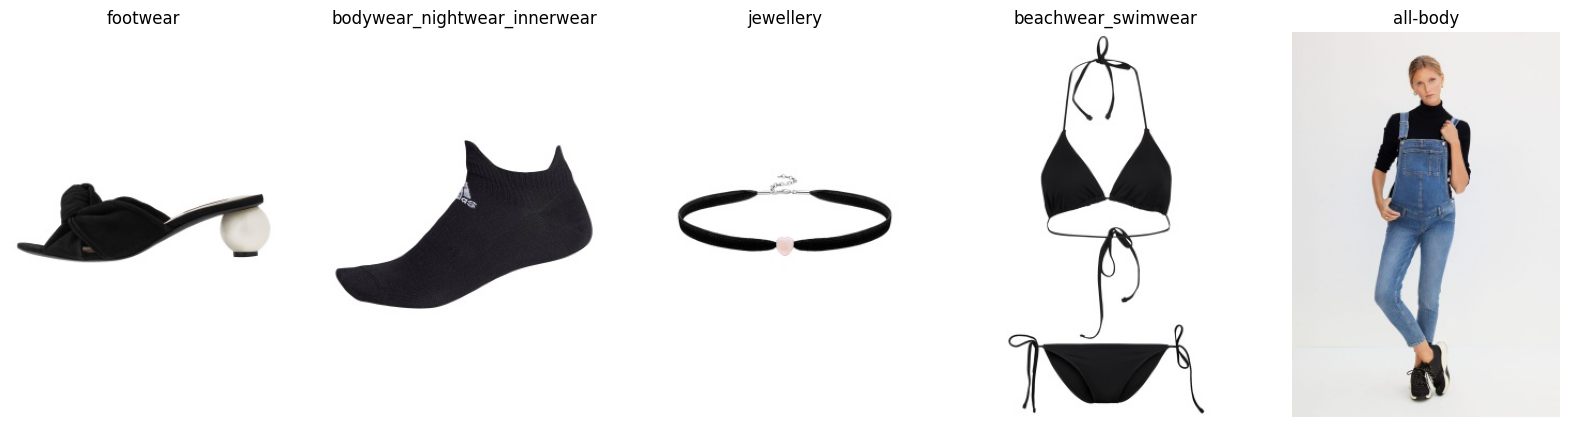

In [18]:
res = get_complementary_items(anchor_idx, style="work")

100%|██████████| 32619/32619 [00:08<00:00, 3922.30it/s]


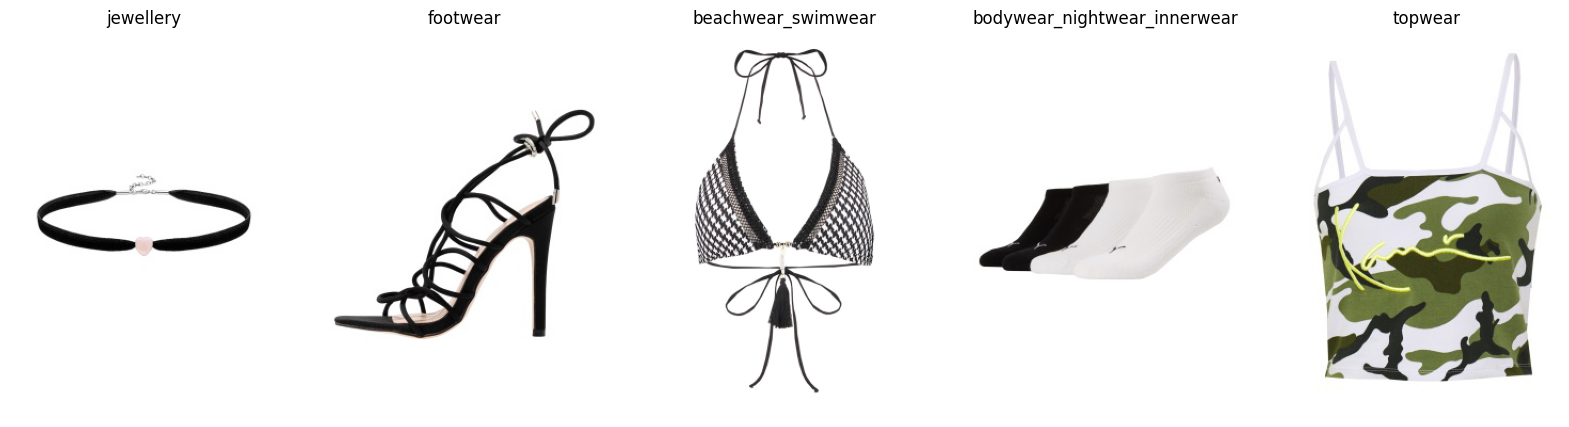

In [19]:
res = get_complementary_items(anchor_idx, style="sporty")

100%|██████████| 32619/32619 [00:08<00:00, 3957.37it/s]


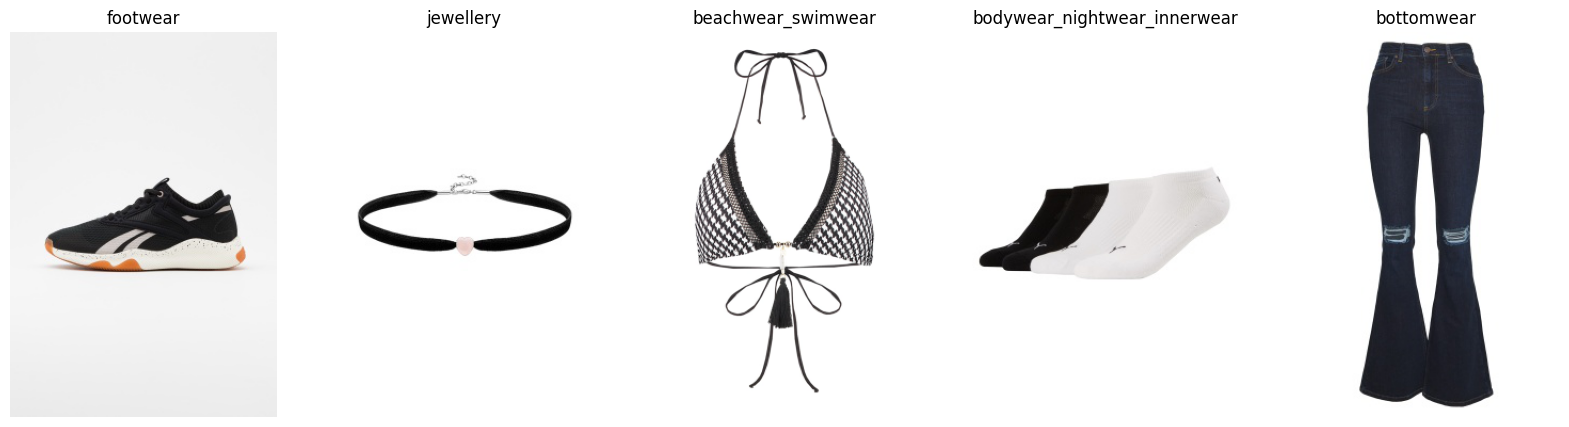

In [20]:
res = get_complementary_items(anchor_idx, style="relax")

In [19]:
image_dist = []
style = "casual"  # 'casual', 'travel', 'party', 'athleisure', 'work', 'sporty', 'relax'

for idx in tqdm(range(len(image_pool))):
    if idx != anchor_idx:
        test_img = image_pool[idx]
        test_cat = test_loader_.im2type[test_img]
        if test_cat == anchor_cat:
            continue
        if data_name == "polyvore":
            condition = test_loader_.get_typespace(anchor_cat, test_cat)
        else:
            condition = test_loader_.get_typespace_with_style(anchor_cat, test_cat, style)
        
        embed1 = embeddings[anchor_idx][condition].unsqueeze(0)
        embed2 = embeddings[idx][condition].unsqueeze(0)
        if metric is None:
            outfit_score = torch.nn.functional.pairwise_distance(
                embed1, embed2, 2)
        else:
            outfit_score = metric(Variable(embed1 * embed2)).data
        heapq.heappush(image_dist, (outfit_score, test_img))
top_images = [heapq.heappop(image_dist) for _ in range(5)]

100%|██████████| 12923/12923 [00:03<00:00, 4167.64it/s]


In [14]:
# Image.open(os.path.join(image_path, top_images[4][1]+".jpg"))

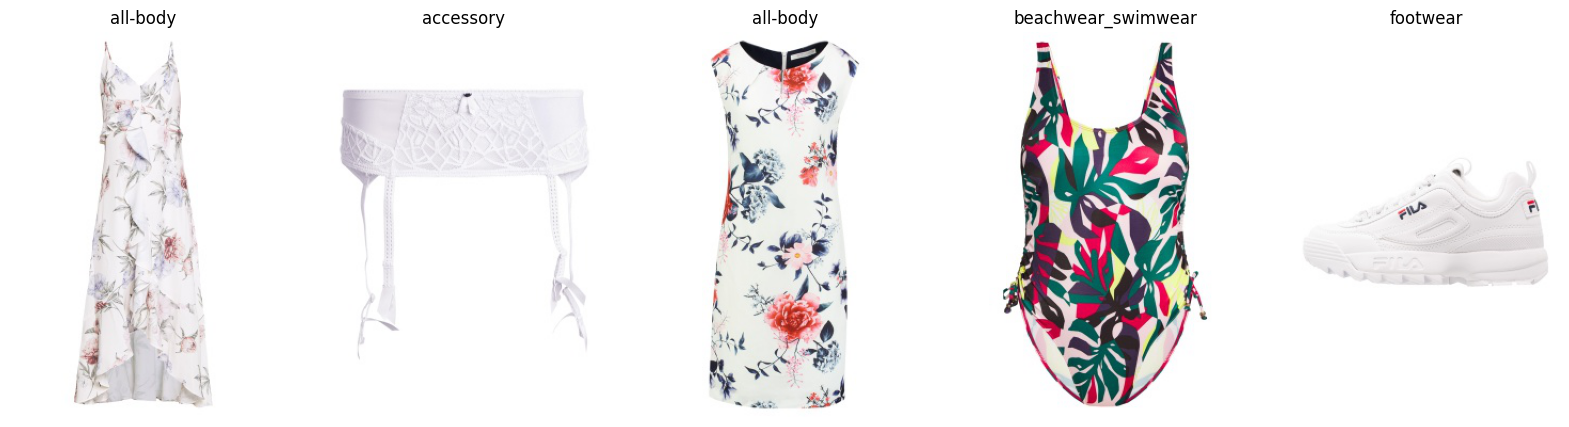

In [20]:
if data_name == "polyvore":
    images = [x[1]+".jpg" for x in top_images]
else:
    images = [x[1] for x in top_images]
categories = [test_loader_.im2type[x[1]] for x in top_images]
plot_images(images, categories, image_dir)

In [103]:
fn = "/recsys_data/RecSys/Zalando_Outfit/female/Compat_AUC_Data/Test/Soft Negative/test_compat_questions_soft_neg_replacement_all_random_seed_1.txt"
with open(fn, 'r') as f:
    lines = f.readlines()
metric = tnet.metric_branch

style_list = ['casual', 'travel', 'party',
              'athleisure', 'work', 'sporty', 'relax']
for line in lines:
    data = line.strip().split()
    style, img1, img2 = style_list[int(data[1])], data[2], data[3]
    cat1, cat2 = test_loader_.im2type[img1], test_loader_.im2type[img2]
    item1, item2 = im2index[img1], im2index[img2]
    condition = test_loader_.get_typespace_with_style(cat1, cat2, style)
    embed1 = embeddings[item1][condition].unsqueeze(0)
    embed2 = embeddings[item2][condition].unsqueeze(0)
    if metric is None:
        outfit_score = torch.nn.functional.pairwise_distance(
            embed1, embed2, 2)
    else:
        outfit_score = metric(Variable(embed1 * embed2)).data
    
    sys.exit()

SystemExit: 

## Create Negative Samples

In [1]:
import os
import json
import numpy as np

from tqdm import tqdm

In [2]:
rootdir = "/recsys_data/RecSys/Zalando_Outfit/female/Outfit_Data"
train_file = "zalando_female_outfit_data_18k_and_new_modified_format_train.json"
valid_file = "zalando_female_outfit_data_18k_and_new_modified_format_val.json"
test_file = "zalando_female_outfit_data_18k_and_new_modified_format_test.json"

In [3]:
def get_negative_item(item_id, item2cat, category2ims):
    item_out = item_id
    item_type = item2cat[item_id]
    candidate_sets = category2ims[item_type]
    # candidate_sets is a collection of items
    attempts = 0
    while item_out == item_id and attempts < 100:
        items = category2ims[item_type]
        item_index = np.random.choice(range(len(items)))
        item_out = items[item_index]
        attempts += 1

    return item_out
    
def get_negative_style(style, style_dict):
    all_styles = list(style_dict.keys())
    style_out = style
    attempts = 0
    while style_out == style and attempts < 100:
        style_index = np.random.choice(range(len(all_styles)))
        style_out = all_styles[style_index]
        attempts += 1
    return style_out


In [4]:
train_json = os.path.join(rootdir, "Train", train_file)
train_data = json.load(open(train_json, 'r'))

item2cat = {}
cat2item = {}
count = 0
pos_examples = list()
for outfit in train_data:
    items = outfit["item_ids"]
    categories = outfit["high_level_cats"]
    style = outfit["outfit_occasion"]
    for i,c in zip(items, categories):
        if c not in cat2item:
            cat2item[c] = []
        cat2item[c].append(i)
        item2cat[i] = c
    pos_examples.append(items)
    count += 1
print(f"{count} examples")

90847 examples


In [5]:
style_dict = {'casual': '0', 'travel': '1', 'party': '2',
              'athleisure': '3', 'work': '4', 'sporty': '5', 'relax': '6'}
with open(os.path.join(rootdir, "compatibility_train.txt"), "w") as fw:
    for outfit in tqdm(train_data):
        items = outfit["item_ids"]
        categories = outfit["high_level_cats"]
        style = outfit['outfit_occasion']
        pos_idx = np.random.choice(range(len(items)))
        pos = items[pos_idx]
        
        # how do you know a negative sample belongs to a specific style
        # i.e., how do you create negative outfit for a specific style?
        neg = get_negative_item(pos, item2cat, cat2item)
        
        # negative outfit
        neg_outfit = items.copy()
        neg_outfit[pos_idx] = neg
        
        pos_out = ['1', style_dict[style]] + items
        fw.write(' '.join(pos_out)+'\n')
        neg_out = ['0', style_dict[style]] + neg_outfit
        fw.write(' '.join(neg_out)+'\n')
        
        # change only the style, keep the original items
        neg_style = get_negative_style(style, style_dict)
        neg_out2 = ['0', style_dict[neg_style]] + items
        fw.write(' '.join(neg_out2)+'\n')


100%|██████████| 90847/90847 [13:00<00:00, 116.41it/s]


In [6]:
valid_json = os.path.join(rootdir, "Val", valid_file)
valid_data = json.load(open(valid_json, 'r'))

count = 0
for outfit in valid_data:
    items = outfit["item_ids"]
    categories = outfit["high_level_cats"]
    for i,c in zip(items, categories):
        cat2item[c].append(i)
        item2cat[i] = c
    count += 1
print(f"{count} examples")

2493 examples


In [7]:
with open(os.path.join(rootdir, "compatibility_valid.txt"), "w") as fw:
    for outfit in tqdm(valid_data):
        items = outfit["item_ids"]
        categories = outfit["high_level_cats"]
        style = outfit['outfit_occasion']
        pos_idx = np.random.choice(range(len(items)))
        pos = items[pos_idx]
        
        # how do you know a negative sample belongs to a specific style
        # i.e., how do you create negative outfit for a specific style?
        neg = get_negative_item(pos, item2cat, cat2item)
        
        # negative outfit
        neg_outfit = items.copy()
        neg_outfit[pos_idx] = neg
        
        pos_out = ['1', style_dict[style]] + items
        fw.write(' '.join(pos_out)+'\n')
        neg_out = ['0', style_dict[style]] + neg_outfit
        fw.write(' '.join(neg_out)+'\n')

        # change only the style, keep the original items
        neg_style = get_negative_style(style, style_dict)
        neg_out2 = ['0', style_dict[neg_style]] + items
        fw.write(' '.join(neg_out2)+'\n')


100%|██████████| 2493/2493 [00:20<00:00, 122.30it/s]


In [8]:
test_json = os.path.join(rootdir, "Test", test_file)
test_data = json.load(open(test_json, 'r'))

count = 0
for outfit in test_data:
    items = outfit["item_ids"]
    categories = outfit["high_level_cats"]
    for i,c in zip(items, categories):
        cat2item[c].append(i)
        item2cat[i] = c
    count += 1
print(f"{count} examples")

5809 examples


In [9]:
with open(os.path.join(rootdir, "compatibility_test.txt"), "w") as fw:
    for outfit in tqdm(test_data):
        items = outfit["item_ids"]
        categories = outfit["high_level_cats"]
        style = outfit['outfit_occasion']
        pos_idx = np.random.choice(range(len(items)))
        pos = items[pos_idx]
        
        # how do you know a negative sample belongs to a specific style
        # i.e., how do you create negative outfit for a specific style?
        neg = get_negative_item(pos, item2cat, cat2item)
        
        # negative outfit
        neg_outfit = items.copy()
        neg_outfit[pos_idx] = neg
        
        pos_out = ['1', style_dict[style]] + items
        fw.write(' '.join(pos_out)+'\n')
        neg_out = ['0', style_dict[style]] + neg_outfit
        fw.write(' '.join(neg_out)+'\n')

        # change only the style, keep the original items
        neg_style = get_negative_style(style, style_dict)
        neg_out2 = ['0', style_dict[neg_style]] + items
        fw.write(' '.join(neg_out2)+'\n')


100%|██████████| 5809/5809 [00:51<00:00, 112.48it/s]
